# EPIC: Elution Profile-based Inference of Protein Complex Membership

Welcome to the EPIC predictor Jupyter web service. Please use the Kitematic file organizes to upload the selected elution profiles. The following parameters need to be set in order to run EPIC:

#### Feature slection:
select which co-elution features to calculate
#### Mode:
The mode which EPIC schould be run, which are experiment only (exp), functional annotation only (fa), both (comb), or bias reduces (BR). We suggest to use bias reduced when wanting to run EPIC using functional annotation without introducing bias into the pipeline.
#### Taxid:
Taxid of the species that was used to generate experimental data
#### Classifier:
Here you can select the classifier used to generate the co-elution profiles. EPIC supports both SVM and random forest. We recommend to use random forest.
#### Functional annotation
Which source for functional annotation to use. The options are File, Genemania, and STRING.
#### Num cores
Number of cores that can be used to calculate co-elution scores. Increasing this number reduces run time if the docher and the machine has multiple cores.
#### Input directory
The directory that contains the elution profiles in tab seperated flat files.


In [24]:
import CalculateCoElutionScores as CS
#os.chdir("/home/EPIC/src")
import utils as utils, shutil, glob
from ipywidgets import widgets, interact, interactive
from IPython.display import HTML, display, Javascript# Basic CyRest Setup
import json, os, sys

#Global paramters for input and output directory. These paramteres need to be changed if you want to run EPIC on local machine instead of Dockers
root_dir = "/Users/florian/workspace/scratch/EPIC_out/" #"/home/"
input_dir = root_dir + 'input' + os.sep 
output_dir = root_dir + 'output' + os.sep

projects =  [f.split(os.sep)[-2] for f in glob.glob(input_dir+"*/")]


def f(**kwargs):
    return None

directoryName_i = widgets.SelectMultiple(
    options=projects,
    value=[projects[0]],
    description='Input',
    disabled=False
)

features_i = interactive(f, MI=False, Bayes=False, Euclidean=False, WCC=False, Jaccard=False, PCCN=False, PCC=False, Apex=False)
num_cores_i = interactive(f, num_cores="1")
clf_i = interactive(f, classifier=("random forest", "SVM"))
target_species_i = interactive(f, target_species="taxid i.e. 6239 (Worm)")
mode_i = widgets.RadioButtons(
    options=['exp', 'fa', 'Comb', 'BR'],
    description='Mode',
    disabled=False
)
fa_source_i = widgets.RadioButtons(
    options=['GM', 'STRING'],
    description='FA source',
    disabled=False
)

display(directoryName_i)
display(features_i)
display(num_cores_i)
display(clf_i)
display(target_species_i)
display(mode_i)
display(fa_source_i)

In [25]:
featuer_selection = [features_i.kwargs[feature_name] for feature_name in ['PCC', 'Jaccard', 'Apex', 'MI', 'Euclidean',  'WCC', 'Bayes', 'PCCN'] ]
num_cores = int(num_cores_i.kwargs['num_cores'])
name = directoryName_i.value[0]
input_dir +=  name
output_dir += name

if os.path.exists(output_dir) == False: 
    os.mkdir(output_dir)
else:
    print "Output dir already exists and removing content"
    shutil.rmtree(output_dir)
    os.mkdir(output_dir)
    
output_dir += os.sep + "Out"
target_taxid = target_species_i.kwargs['target_species']
use_rf = clf_i.kwargs['classifier'] != 'SVM'
if use_rf:
    output_dir += ".rf"
else:
    output_dir += ".svm"
mode= "exp"

#Stdout for debug
print num_cores
print(featuer_selection)
print use_rf
print target_taxid
print input_dir
print output_dir


Output dir already exists and removing content
4
[False, True, False, True, False, True, False, False]
True
6239
/Users/florian/workspace/scratch/EPIC_out/input/test
/Users/florian/workspace/scratch/EPIC_out/output/test/Out.rf


In [26]:
#Create feature combination
all_scores = [CS.Pearson(), CS.Jaccard(), CS.Apex(), CS.MutualInformation(2), CS.Euclidiean(), CS.Wcc(), CS.Bayes(3), CS.Poisson(5)]
this_scores = []
for i, selection in enumerate(featuer_selection):
	if selection: this_scores.append(all_scores[i])

# Stdout for debug
print this_scores


[<CalculateCoElutionScores.Jaccard instance at 0x144c15dd0>, <CalculateCoElutionScores.MutualInformation instance at 0x144c15e18>, <CalculateCoElutionScores.Wcc instance at 0x144c15fc8>]


## Initializing the classifier

In [27]:
# Initialize CLF
clf = CS.CLF_Wrapper(num_cores, use_rf)

using Random forest


# Loading Elution prfile data
EPIC loads in the elution data and removes proteins that are observed in exactly one fraction per experiment. Optimally the percentage of removed proteins should not exceed 50% 

In [28]:
# load elution data
foundprots, elution_datas = utils.load_data(input_dir, this_scores)

finished processing /Users/florian/workspace/scratch/EPIC_out/input/test/BeadsA_Contrast_1000_fraction_99.txtmodifed.txt
 removed 591 (0.32) proteins with counts in only one fraction
finished processing /Users/florian/workspace/scratch/EPIC_out/input/test/BeadsALF_Contrast_1000_fraction_99.txtmodifed.txt
 removed 563 (0.32) proteins with counts in only one fraction
finished processing /Users/florian/workspace/scratch/EPIC_out/input/test/BeadsB_Contrast_1000_fraction_99.txtmodifed.txt
 removed 571 (0.28) proteins with counts in only one fraction
finished processing /Users/florian/workspace/scratch/EPIC_out/input/test/BeadsBNF_Contrast_1000_fraction_99.txtmodifed.txt
 removed 471 (0.28) proteins with counts in only one fraction


# Generating reference data
In this step EPIC automatically generate reference data taken from CORUM, Intact, and GO. We recommend the final number of complexes to be at least 100.

In [31]:
# Generate reference data set
all_gs = utils.create_goldstandard(target_taxid, foundprots)

Total number of complexes 2791 in Training
Number of complexes after ortholog mapping 1912 complexes in Training
After removing not indetified proteins 157 number of complexes in Training
After size filtering 157 number of complexes in Training
After mergning 119 number of complexes in Training


# Calculating co-elution scores
This is the most time intensive step of EPIC and on average take 20 min per co-elution score per experiment.

In [32]:
# Caculating scores
scoreCalc = CS.CalculateCoElutionScores(this_scores, elution_datas, output_dir + ".scores.txt", num_cores=num_cores)
#scoreCalc.calculate_coelutionDatas(all_gs)
# For debug readin precalculated co-elution scores
scoreCalc.readTable("/Users/florian/workspace/scratch/EPIC_out/output/Out.rf.scores.txt", all_gs)

# Generating reference training split
Considere increasing experimental data, or removing train/eval split in case there are not enough referenc eedges to balance the data sets.

In [33]:
train, eval = all_gs.split_into_holdout_training(set(scoreCalc.ppiToIndex.keys()))

# Classifier evaluation

In [34]:
# Evaluate classifier
utils.bench_clf(scoreCalc, train, eval, clf, output_dir, verbose=True, format="png")

Precision
0.815533980583
Recall
0.30053667263
F-Measure
0.439215686275
AUC PR
0.630765981368
AUC ROC
0.641343958673


## Precision and recall values for various classifier confidence cutoffs

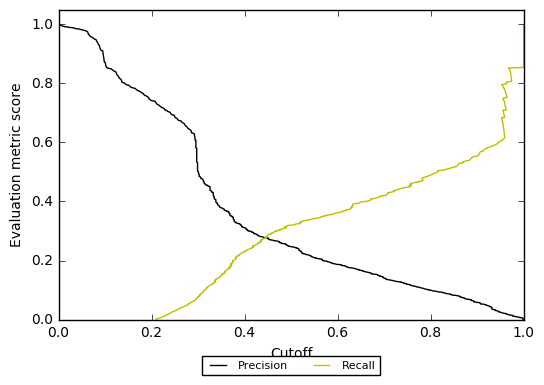

In [35]:
from IPython.display import Image
Image(filename=output_dir + ".cutoff.png")

## Precision-recall curve

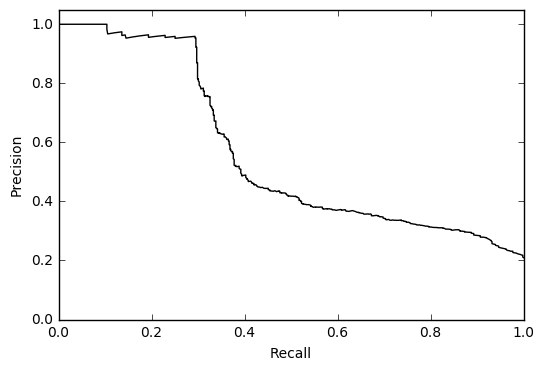

In [36]:
Image(filename=output_dir + ".pr.png")

## ROC curve

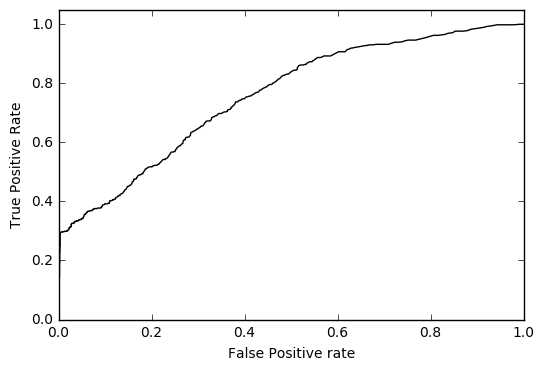

In [37]:
Image(filename=output_dir + ".roc.png")

In [38]:
# Predicting interaction network


functionalData = ""
if mode != "exp":
    functionalData = utils.get_FA_data(anno_source)

# Predict protein interaction
network =  utils.make_predictions(scoreCalc, mode, clf, all_gs, functionalData)
outFH = open("%s.%s.pred.txt" % (output_dir, mode), "w")
print >> outFH, "\n".join(network)
outFH.close()

(5002, 12)
to predict: 125030


In [39]:
# Predicting clusters
utils.predict_clusters("%s.%s.pred.txt" % (output_dir, mode), "%s.%s.clust.txt" % (output_dir, mode))

# Clustering evaluation

In [40]:
import GoldStandard as GS
# Evaluating predicted clusters
pred_clusters = GS.Clusters(False)
pred_clusters.read_file("%s.%s.clust.txt" % (output_dir, mode))
#utils.clustering_evaluation(train.complexes, pred_clusters, "Train", True)
utils.clustering_evaluation(eval.complexes, pred_clusters, "", True)

 mmr	0.326259811361
 overlapp	0.094241
 simcoe	0.146597
 mean_simcoe_overlap	0.141361
 sensetivity	0.161003236246
 ppv	0.501538461538
 accuracy	0.284164240202
 sep	0.211733549941


('0.326259811361\t0.094241\t0.146597\t0.141361\t0.161003236246\t0.501538461538\t0.284164240202\t0.211733549941',
 ' mmr\t overlapp\t simcoe\t mean_simcoe_overlap\t sensetivity\t ppv\t accuracy\t sep')

In [19]:
# Uncomment these lines in order to update the Cytoscape.js extension
# ====================================================================
import notebook.nbextensions
notebook.nbextensions.install_nbextension('https://cdnjs.cloudflare.com/ajax/libs/cytoscape/2.7.14/cytoscape.js', user=True)
# ====================================================================

u'/Users/florian/Library/Jupyter/nbextensions/cytoscape.js'

In [20]:
%%javascript

// Use the Cytoscape.js extension and make cytoscape global
require(['nbextensions/cytoscape'], function (cytoscape) {
    window.cytoscape = cytoscape;
});

<IPython.core.display.Javascript object>

In [21]:
all_eData_head, all_eData_scores = utils.elutionDatas_to_treeview(elution_datas, foundprots)
clust_json, clust_edges, clust_nodes = utils.clusters_to_json(pred_clusters, network, all_eData_head, all_eData_scores)

# Clustering network

In [22]:
#clust_json, clust_edges, clust_nodes = clusters_to_json(pred_clusters, network)
clust_cy_js = utils.json_to_cy_js("clust_cy", clust_json)
clust_cy_div = widgets.HTML(value="""<div id='clust_cy' style="width: 100%; height: 500px; background: #f0f0f0;"></div>""")
clust_js_script = widgets.HTML(value = clust_cy_js)
display(clust_cy_div)
display(clust_js_script)

# Sending cluster data to running cytoscape instance

In [ ]:
import requests

BASE, DATA, HEADERS = utils.prep_network_for_cy(clust_nodes, clust_edges)
res = requests.delete(BASE + 'session')
json.dumps(res.json())
req = requests.post(BASE + 'networks', data=DATA, headers=HEADERS)
